# Projeto Final 1 - fine-tunning de uma CNN para Classificação

## Aluna:

* **Nome:** Thaís Rezende e Barbosa
* **E-mail:** trb@cesar.school

## Elaboração do dataset

O projeto consiste em uma rede CNN para classicação de Pokémons. O dataset é composto por 10 tipos diferentes de Pokémon.

Critérios de avaliação:

* Construção do Dataset
* Data Augmentation
* Uso de Modelos Pré-Treinados
* Construção do Modelo Classificador
* Congelamento de Camadas
* Treinamento e Curvas de Desempenho

In [ ]:
# Baixa o dataset
! git clone https://github.com/thaisrezendeb/dataset_pokemon_cnn.git

Cloning into 'dataset_pokemon_cnn'...
remote: Enumerating objects: 835, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 835 (delta 0), reused 3 (delta 0), pack-reused 830 (from 2)
Receiving objects: 100% (835/835), 320.47 MiB | 15.26 MiB/s, done.
Updating files: 100% (802/802), done.


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, device=device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader, device=device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()

In [ ]:
# ! rm -rf `find -type d -name .ipynb_checkpoints`

In [ ]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = "/content/dataset_pokemon_cnn/pokemon"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]
100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Epoch 1, Train Loss: 2.321, Train Accuracy: 15.72%
Epoch 1, Val Loss: 2.077, Val Accuracy: 31.03%


100%|██████████| 19/19 [00:13<00:00,  1.41it/s]


Epoch 2, Train Loss: 1.954, Train Accuracy: 35.95%
Epoch 2, Val Loss: 1.680, Val Accuracy: 49.75%


100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


Epoch 3, Train Loss: 1.627, Train Accuracy: 52.01%
Epoch 3, Val Loss: 1.368, Val Accuracy: 68.97%


100%|██████████| 19/19 [00:14<00:00,  1.32it/s]


Epoch 4, Train Loss: 1.398, Train Accuracy: 61.71%
Epoch 4, Val Loss: 1.179, Val Accuracy: 70.44%


100%|██████████| 19/19 [00:13<00:00,  1.40it/s]


Epoch 5, Train Loss: 1.250, Train Accuracy: 64.55%
Epoch 5, Val Loss: 0.978, Val Accuracy: 75.37%


100%|██████████| 19/19 [00:13<00:00,  1.37it/s]


Epoch 6, Train Loss: 1.135, Train Accuracy: 68.39%
Epoch 6, Val Loss: 0.909, Val Accuracy: 78.33%


100%|██████████| 19/19 [00:13<00:00,  1.43it/s]


Epoch 7, Train Loss: 1.101, Train Accuracy: 68.06%
Epoch 7, Val Loss: 0.847, Val Accuracy: 77.83%


100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


Epoch 8, Train Loss: 1.019, Train Accuracy: 68.39%
Epoch 8, Val Loss: 0.738, Val Accuracy: 82.76%


100%|██████████| 19/19 [00:13<00:00,  1.41it/s]


Epoch 9, Train Loss: 0.939, Train Accuracy: 72.07%
Epoch 9, Val Loss: 0.705, Val Accuracy: 82.76%


100%|██████████| 19/19 [00:13<00:00,  1.37it/s]


Epoch 10, Train Loss: 0.936, Train Accuracy: 71.40%
Epoch 10, Val Loss: 0.637, Val Accuracy: 80.30%


100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


Epoch 11, Train Loss: 0.816, Train Accuracy: 76.09%
Epoch 11, Val Loss: 0.622, Val Accuracy: 83.74%


100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


Epoch 12, Train Loss: 0.842, Train Accuracy: 73.58%
Epoch 12, Val Loss: 0.556, Val Accuracy: 83.25%


100%|██████████| 19/19 [00:13<00:00,  1.44it/s]


Epoch 13, Train Loss: 0.760, Train Accuracy: 77.93%
Epoch 13, Val Loss: 0.589, Val Accuracy: 82.27%


100%|██████████| 19/19 [00:13<00:00,  1.44it/s]


Epoch 14, Train Loss: 0.739, Train Accuracy: 79.26%
Epoch 14, Val Loss: 0.512, Val Accuracy: 84.24%


100%|██████████| 19/19 [00:13<00:00,  1.44it/s]


Epoch 15, Train Loss: 0.772, Train Accuracy: 76.76%
Epoch 15, Val Loss: 0.536, Val Accuracy: 83.74%


100%|██████████| 19/19 [00:13<00:00,  1.41it/s]


Epoch 16, Train Loss: 0.710, Train Accuracy: 79.43%
Epoch 16, Val Loss: 0.529, Val Accuracy: 85.71%


100%|██████████| 19/19 [00:13<00:00,  1.40it/s]


Epoch 17, Train Loss: 0.722, Train Accuracy: 76.09%
Epoch 17, Val Loss: 0.474, Val Accuracy: 86.21%


100%|██████████| 19/19 [00:13<00:00,  1.39it/s]


Epoch 18, Train Loss: 0.713, Train Accuracy: 79.43%
Epoch 18, Val Loss: 0.454, Val Accuracy: 85.71%


100%|██████████| 19/19 [00:13<00:00,  1.40it/s]


Epoch 19, Train Loss: 0.648, Train Accuracy: 79.60%
Epoch 19, Val Loss: 0.498, Val Accuracy: 85.22%


100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


Epoch 20, Train Loss: 0.634, Train Accuracy: 80.43%
Epoch 20, Val Loss: 0.433, Val Accuracy: 86.21%


100%|██████████| 19/19 [00:13<00:00,  1.43it/s]


Epoch 21, Train Loss: 0.615, Train Accuracy: 80.77%
Epoch 21, Val Loss: 0.478, Val Accuracy: 84.73%


100%|██████████| 19/19 [00:13<00:00,  1.44it/s]


Epoch 22, Train Loss: 0.658, Train Accuracy: 79.43%
Epoch 22, Val Loss: 0.465, Val Accuracy: 86.21%


100%|██████████| 19/19 [00:13<00:00,  1.43it/s]


Epoch 23, Train Loss: 0.616, Train Accuracy: 80.77%
Epoch 23, Val Loss: 0.443, Val Accuracy: 86.21%


100%|██████████| 19/19 [00:13<00:00,  1.43it/s]


Epoch 24, Train Loss: 0.567, Train Accuracy: 81.77%
Epoch 24, Val Loss: 0.429, Val Accuracy: 86.70%


100%|██████████| 19/19 [00:13<00:00,  1.43it/s]


Epoch 25, Train Loss: 0.566, Train Accuracy: 81.94%
Epoch 25, Val Loss: 0.396, Val Accuracy: 87.19%


100%|██████████| 19/19 [00:13<00:00,  1.41it/s]


Epoch 26, Train Loss: 0.573, Train Accuracy: 81.94%
Epoch 26, Val Loss: 0.409, Val Accuracy: 87.19%


100%|██████████| 19/19 [00:13<00:00,  1.43it/s]


Epoch 27, Train Loss: 0.613, Train Accuracy: 79.43%
Epoch 27, Val Loss: 0.398, Val Accuracy: 88.18%


100%|██████████| 19/19 [00:13<00:00,  1.41it/s]


Epoch 28, Train Loss: 0.533, Train Accuracy: 83.78%
Epoch 28, Val Loss: 0.383, Val Accuracy: 87.68%


100%|██████████| 19/19 [00:13<00:00,  1.38it/s]


Epoch 29, Train Loss: 0.523, Train Accuracy: 84.45%
Epoch 29, Val Loss: 0.423, Val Accuracy: 89.16%


100%|██████████| 19/19 [00:13<00:00,  1.41it/s]


Epoch 30, Train Loss: 0.572, Train Accuracy: 82.27%
Epoch 30, Val Loss: 0.407, Val Accuracy: 88.18%


100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


Epoch 31, Train Loss: 0.511, Train Accuracy: 84.78%
Epoch 31, Val Loss: 0.398, Val Accuracy: 88.18%


100%|██████████| 19/19 [00:13<00:00,  1.43it/s]


Epoch 32, Train Loss: 0.548, Train Accuracy: 81.61%
Epoch 32, Val Loss: 0.346, Val Accuracy: 88.67%


100%|██████████| 19/19 [00:13<00:00,  1.43it/s]


Epoch 33, Train Loss: 0.549, Train Accuracy: 82.27%
Epoch 33, Val Loss: 0.360, Val Accuracy: 88.18%


100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


Epoch 34, Train Loss: 0.480, Train Accuracy: 85.28%
Epoch 34, Val Loss: 0.442, Val Accuracy: 88.67%


100%|██████████| 19/19 [00:13<00:00,  1.43it/s]


Epoch 35, Train Loss: 0.449, Train Accuracy: 86.79%
Epoch 35, Val Loss: 0.341, Val Accuracy: 88.18%


100%|██████████| 19/19 [00:13<00:00,  1.43it/s]


Epoch 36, Train Loss: 0.479, Train Accuracy: 85.12%
Epoch 36, Val Loss: 0.363, Val Accuracy: 90.64%


100%|██████████| 19/19 [00:13<00:00,  1.38it/s]


Epoch 37, Train Loss: 0.413, Train Accuracy: 88.46%
Epoch 37, Val Loss: 0.381, Val Accuracy: 89.16%


100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


Epoch 38, Train Loss: 0.487, Train Accuracy: 84.62%
Epoch 38, Val Loss: 0.350, Val Accuracy: 88.18%


100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


Epoch 39, Train Loss: 0.536, Train Accuracy: 82.78%
Epoch 39, Val Loss: 0.354, Val Accuracy: 89.16%


100%|██████████| 19/19 [00:13<00:00,  1.41it/s]


Epoch 40, Train Loss: 0.443, Train Accuracy: 86.79%
Epoch 40, Val Loss: 0.362, Val Accuracy: 88.18%


100%|██████████| 19/19 [00:13<00:00,  1.43it/s]


Epoch 41, Train Loss: 0.451, Train Accuracy: 86.12%
Epoch 41, Val Loss: 0.338, Val Accuracy: 89.16%


100%|██████████| 19/19 [00:13<00:00,  1.43it/s]


Epoch 42, Train Loss: 0.495, Train Accuracy: 83.28%
Epoch 42, Val Loss: 0.329, Val Accuracy: 89.66%


100%|██████████| 19/19 [00:13<00:00,  1.43it/s]


Epoch 43, Train Loss: 0.407, Train Accuracy: 87.96%
Epoch 43, Val Loss: 0.413, Val Accuracy: 87.68%


100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


Epoch 44, Train Loss: 0.422, Train Accuracy: 86.45%
Epoch 44, Val Loss: 0.344, Val Accuracy: 88.67%


100%|██████████| 19/19 [00:13<00:00,  1.40it/s]


Epoch 45, Train Loss: 0.462, Train Accuracy: 85.45%
Epoch 45, Val Loss: 0.404, Val Accuracy: 88.67%


100%|██████████| 19/19 [00:13<00:00,  1.41it/s]


Epoch 46, Train Loss: 0.381, Train Accuracy: 88.29%
Epoch 46, Val Loss: 0.419, Val Accuracy: 87.19%


100%|██████████| 19/19 [00:13<00:00,  1.41it/s]


Epoch 47, Train Loss: 0.389, Train Accuracy: 87.96%
Epoch 47, Val Loss: 0.356, Val Accuracy: 87.19%


100%|██████████| 19/19 [00:13<00:00,  1.39it/s]


Epoch 48, Train Loss: 0.378, Train Accuracy: 87.12%
Epoch 48, Val Loss: 0.387, Val Accuracy: 89.66%


100%|██████████| 19/19 [00:13<00:00,  1.41it/s]


Epoch 49, Train Loss: 0.373, Train Accuracy: 88.63%
Epoch 49, Val Loss: 0.384, Val Accuracy: 87.19%


100%|██████████| 19/19 [00:13<00:00,  1.39it/s]


Epoch 50, Train Loss: 0.357, Train Accuracy: 89.97%
Epoch 50, Val Loss: 0.373, Val Accuracy: 87.68%


100%|██████████| 19/19 [00:13<00:00,  1.38it/s]


Epoch 51, Train Loss: 0.461, Train Accuracy: 84.95%
Epoch 51, Val Loss: 0.343, Val Accuracy: 89.16%


100%|██████████| 19/19 [00:13<00:00,  1.40it/s]


Epoch 52, Train Loss: 0.369, Train Accuracy: 89.80%
Epoch 52, Val Loss: 0.367, Val Accuracy: 89.16%


100%|██████████| 19/19 [00:14<00:00,  1.33it/s]


Epoch 53, Train Loss: 0.399, Train Accuracy: 88.13%
Epoch 53, Val Loss: 0.352, Val Accuracy: 88.18%


100%|██████████| 19/19 [00:13<00:00,  1.39it/s]


Epoch 54, Train Loss: 0.378, Train Accuracy: 87.63%
Epoch 54, Val Loss: 0.385, Val Accuracy: 87.19%


100%|██████████| 19/19 [00:13<00:00,  1.40it/s]


Epoch 55, Train Loss: 0.346, Train Accuracy: 89.30%
Epoch 55, Val Loss: 0.381, Val Accuracy: 87.19%


100%|██████████| 19/19 [00:13<00:00,  1.40it/s]


Epoch 56, Train Loss: 0.364, Train Accuracy: 87.96%
Epoch 56, Val Loss: 0.344, Val Accuracy: 88.18%


100%|██████████| 19/19 [00:13<00:00,  1.41it/s]


Epoch 57, Train Loss: 0.389, Train Accuracy: 85.79%
Epoch 57, Val Loss: 0.321, Val Accuracy: 89.16%


100%|██████████| 19/19 [00:13<00:00,  1.40it/s]


Epoch 58, Train Loss: 0.354, Train Accuracy: 89.30%
Epoch 58, Val Loss: 0.354, Val Accuracy: 89.16%


100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


Epoch 59, Train Loss: 0.384, Train Accuracy: 88.29%
Epoch 59, Val Loss: 0.353, Val Accuracy: 86.70%


100%|██████████| 19/19 [00:13<00:00,  1.41it/s]


Epoch 60, Train Loss: 0.358, Train Accuracy: 88.29%
Epoch 60, Val Loss: 0.329, Val Accuracy: 87.68%
Treinamento concluído


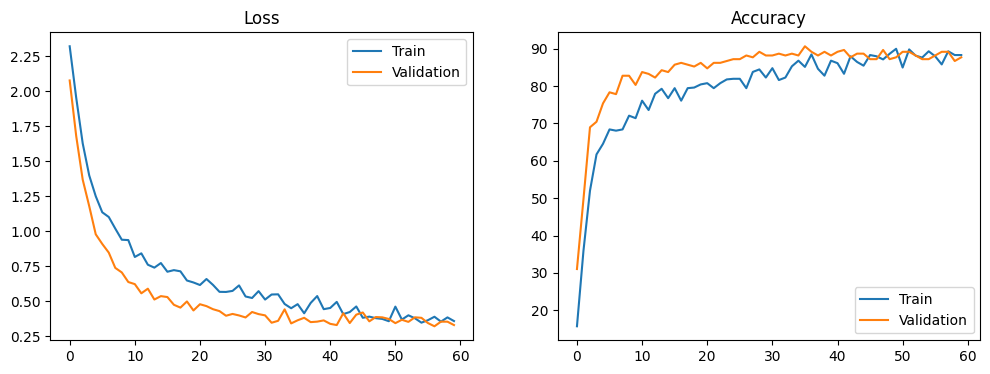

Acurácia da rede na base de teste: 87.68%


In [ ]:
# Utilizando pesos pré-treinados
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Congelar todas as camadas
for param in model.parameters():
    param.requires_grad = False

# Descongela a última camadas
for param in model.layer4.parameters():
    param.requires_grad = True

# Substituir a última camada
model.fc = nn.Linear(model.fc.in_features, len(train_set.classes))
model = model.to(device)

# Treinando a CNN
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=60)

plot_history(history)
test_model(model, val_loader)

In [ ]:
def plot_and_predict(model, image, class_names, device=device):
    model.eval()
    image = image.to(device)
    outputs = model(image.unsqueeze(0))
    _, predicted = torch.max(outputs.data, 1)
    probs = F.softmax(outputs, dim=1)[0] * 100
    prob = probs[predicted].item()

    # image between 0 and 1
    image = torch.clamp(image * 0.225 + 0.45, 0, 1)
    title = f'Classe: {class_names[predicted]} ({prob:.2f}%)'
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.title(title)
    plt.axis('off')
    plt.show()

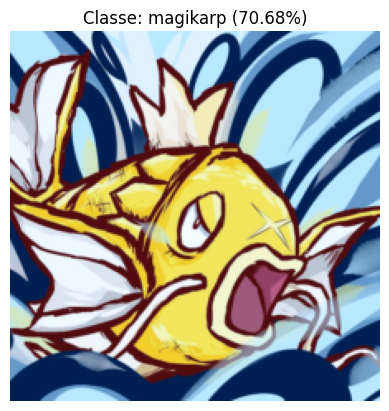

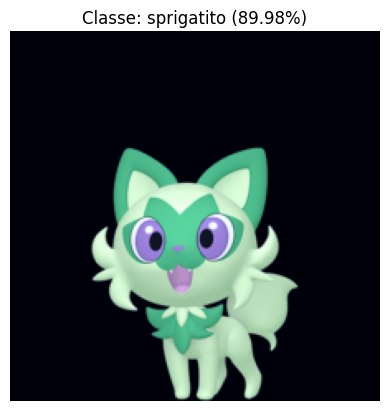

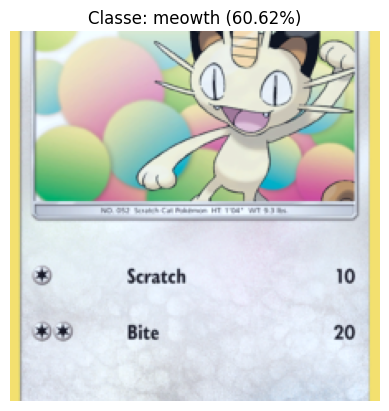

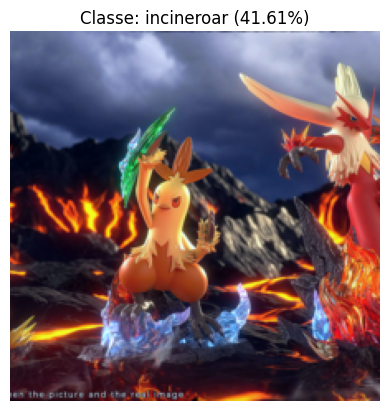

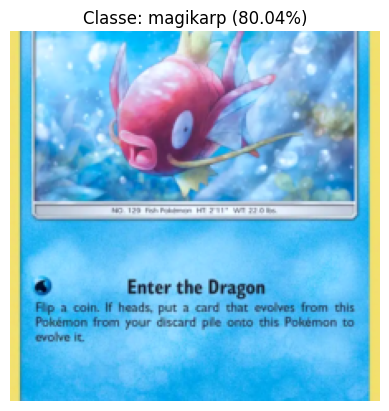

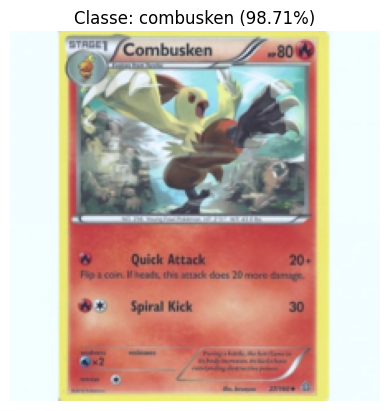

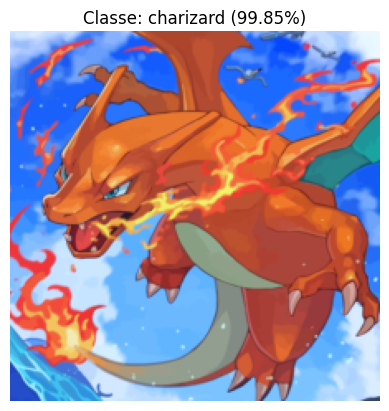

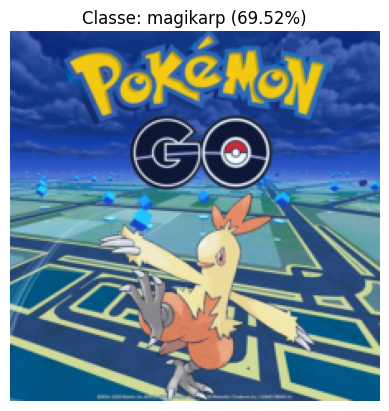

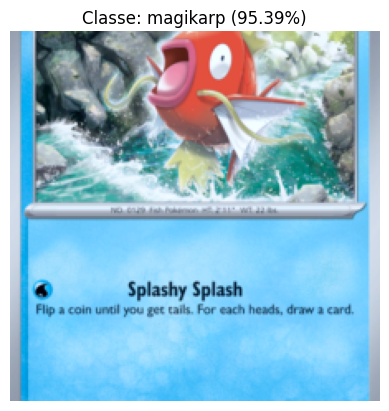

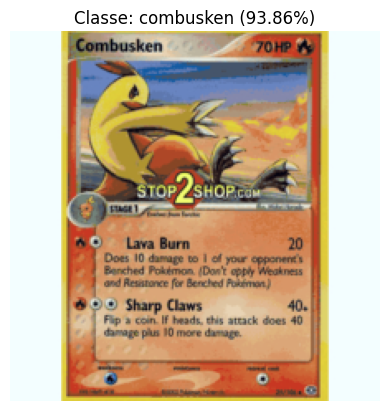

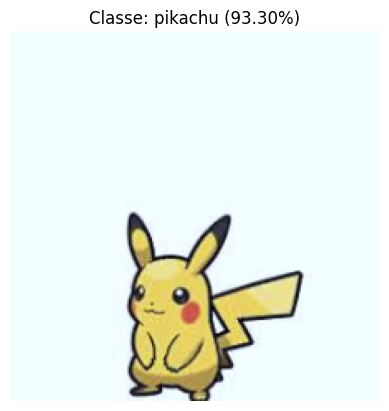

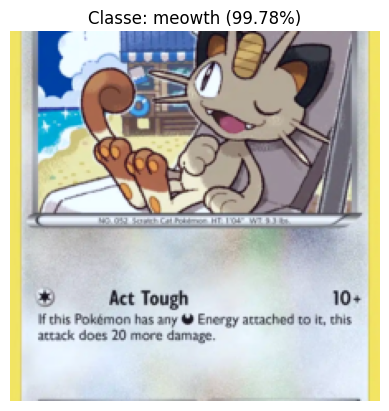

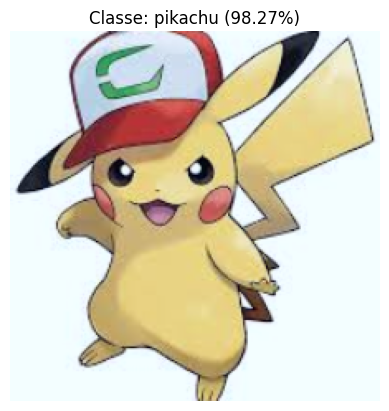

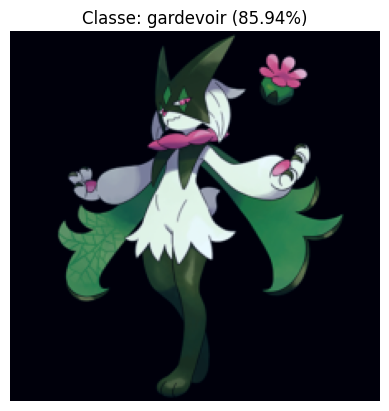

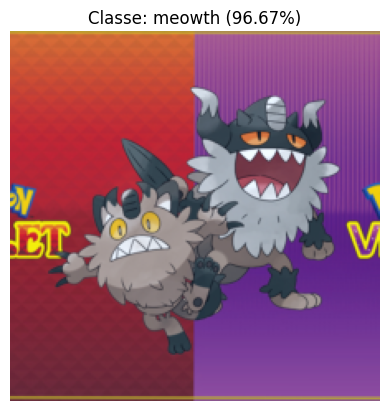

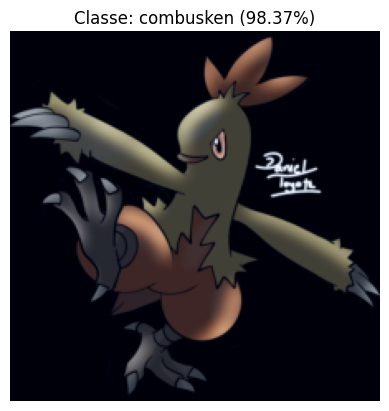

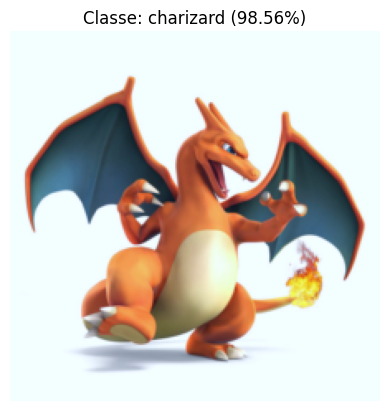

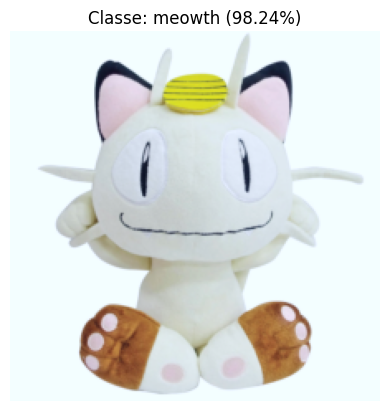

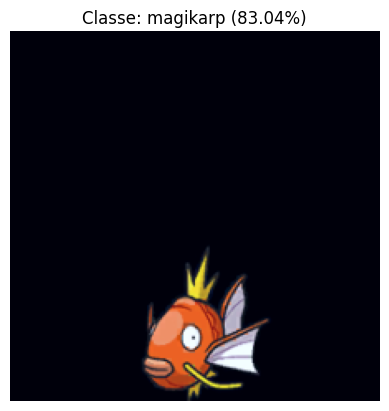

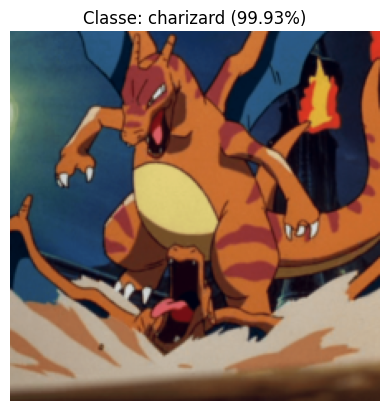

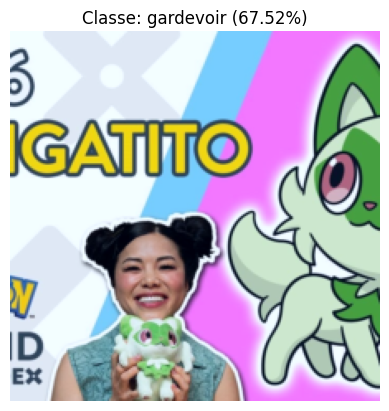

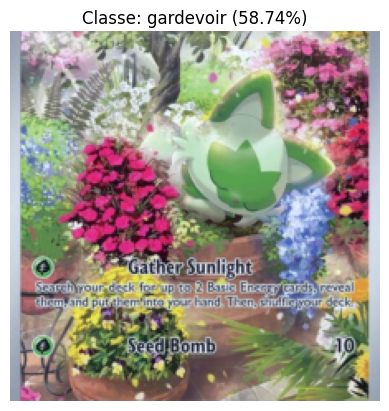

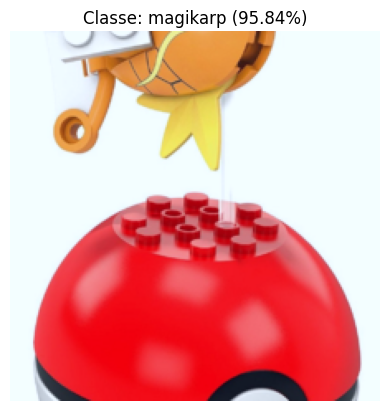

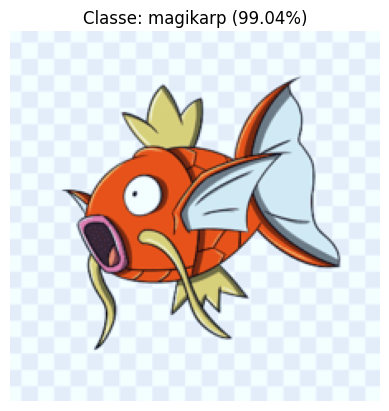

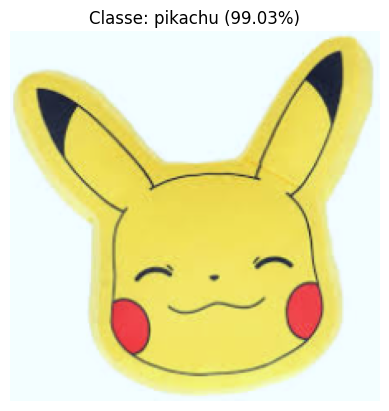

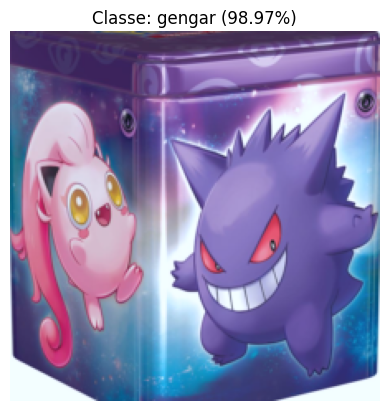

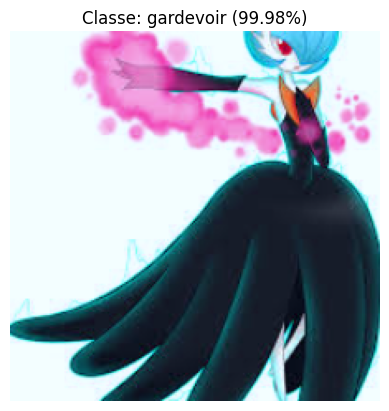

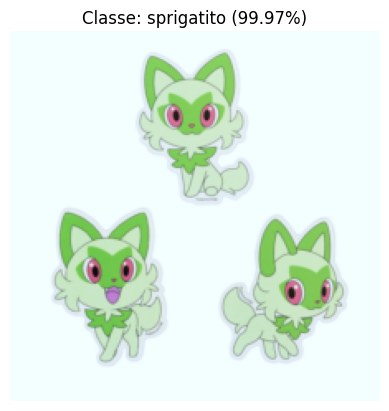

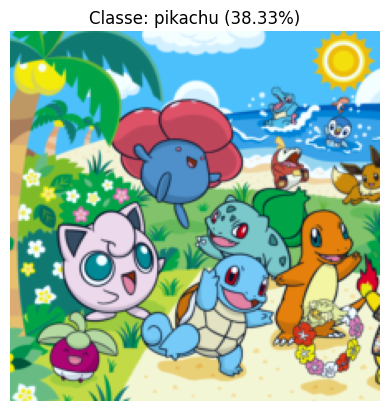

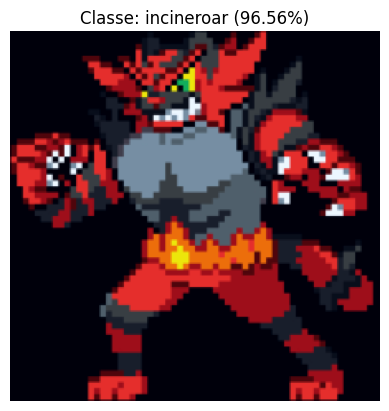

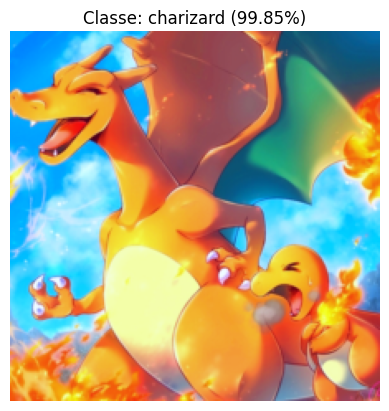

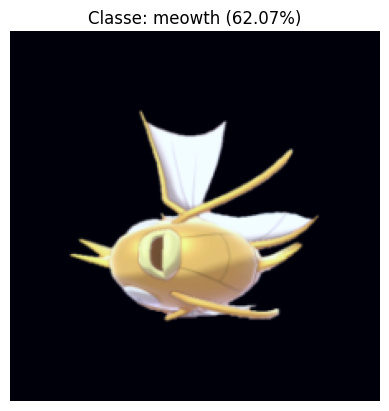

In [ ]:
# Avaliação por amostragem
images, labels = next(iter(val_loader))

for image, label in zip(images, labels):
    plot_and_predict(model, image, val_set.classes)

# Conclusão

O projeto final 1 consiste na realização de um fine-tunning de uma rede CNN para realização da classificação de diferentes tipos de Pokémon. Para o treinamento foi criado um *dataset* com imagens de dez categorias de Pokémon, sendo:

* Incineroar
* Magikarp
* Sprigatito
* Combusken
* Pikachu
* Meowth
* Charizard
* Gengar
* Gardevoir
* Magnemite

Dada a quantidade reduzida de amostras do *dataset*, foi necessário realizar um *data augmentation* da base de treino através dos métodos a seguir:

* Inversão horizontal (RandomHorizontalFlip)
* Inversão vertical (RandomVerticalFlip)
* Rotação em 15 graus (RandomRotation)
* Transformação afim (RandomAffine)
* Transformação de cor (ColorJitter)
* Escalas de cinza (RandomGrayscale)

A rede CNN criada é composta pela rede ResNet 18 utilizando pesos pré-treinados. O treino foi realizado congelando-se todas as camadas da rede, a exceção da camada 4, e substituindo-se a última camada por uma linear. O critério de avaliação do modelo foi feito aplicando-se a perda por entropia cruzada (CrossEntropyLoss) e o otimizador utilizado foi o SGD.

O treinamento foi realizado em 60 épocas e batch size de 32. Pelas curvas de perda e acurácia conclui-se que não houve *overfitting* do modelo. A perda final foi de 0,358 e 0,329 para treino e validação, respectivamente, e a acurácia de 88,29% para treino e 87,68% para validação.

Pela avaliação amostral percebe-se que o modelo se comporta bem, mas ainda erra em alguns casos. Para efeito de estudos, considera-se que a proximidade em 90% de acurácia é um bom resultado, dado que não existe uma exigência por maior precisão.

Para melhorar ainda mais o modelo, pode-se trocar o otimizador, como por exemplo o Adam, e também a rede pré-treinada, para identificar aquela que melhor se adapta ao dataset em estudo.

Conclui-se que, para o objetivo de estudo do *fine-tunning* de uma rede CNN para classificação, este projeto atingiu o propósito e foi útil para absorver melhor os conceitos apresentados em sala de aula. Desafios como a composição do *dataset* e o processo de leitura e transformação para a entrada da rede foram superados através do estudo dos modelos apresentados em sala e da documentação da biblioteca PyTorch.